In [1]:
from numpy import zeros
from numpy import ones
import numpy as np
import h5py
from sklearn import model_selection
from scipy.ndimage import interpolation
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv1D,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose,BatchNormalization,MaxPooling2D,UpSampling1D
from keras.layers import Conv1DTranspose
from keras.layers import LeakyReLU
from keras.layers import ReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from scipy import stats
import keras
from IPython import display
from keras import backend
import os
from matplotlib import pyplot as plt
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np

import numpy as np
import statistics as stats
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
import os
import keras
import tensorflow as tf
from keras import Sequential
from keras.layers import Convolution1D as Conv1D
from keras.layers import Dropout, Flatten, MaxPooling1D, Dense, AveragePooling1D, BatchNormalization
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from random import randint
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import random
import h5py
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import StandardScaler 
from keras.optimizers import schedules
import math
from matplotlib import colors
from IPython import display

  
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D

#latex font:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

os.environ['KERAS_BACKEND']='tensorflow'
150, 3600, 1


(150, 3600, 1)

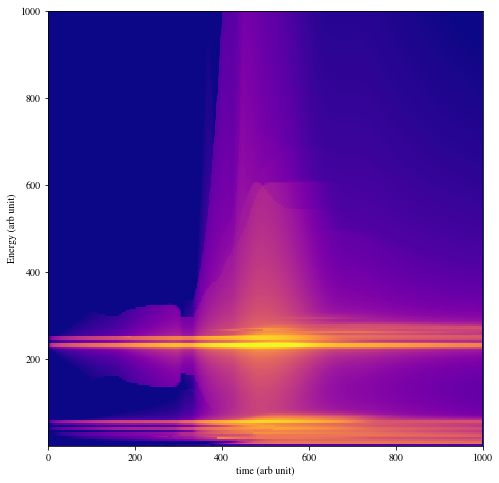

In [3]:
hf = h5py.File('/Users/harry/Documents/plugg/exjobb/files_from_davinci/database_conv/VDB.hdf5','r')
tm = np.array(hf['/data_1/time/spectrum_time_matrix'])
tm[tm == 0.0] = 1E-40  # log doesn't like zeros
def glowplot(tm):
    HPEV = 4.135667516E-15  # Planks constant [eV s]
    ERG2J = 1E-7
    E1 = 2000  # [eV]
    E2 = E1 * 1.001  # [eV]
    mult = HPEV / (E2 - E1)
    tm = (4*np.pi * ERG2J * tm)/mult
    fig,ax=plt.subplots(figsize=(8,8))
    plt.ylim([1E-1, 1E3])
    im=plt.imshow(tm,norm=colors.LogNorm(),extent=[0, 1000, 0, 1000],cmap='plasma',origin='lower', interpolation='nearest')
    #ax.set_yscale('log')
    plt.ylabel('Energy (arb unit)')
    plt.xlabel('time (arb unit)')
    plt.clim([1E3, 1E12])
glowplot(tm)

In [2]:
def scaleback_pic(pic,minval,maxval):
    U = pic*(maxval-minval)
    U = U + np.ones(U.shape)*minval
    return np.exp(U)
    

In [3]:
def prepare_data():



    #Define the hdf5 reader and extract the datasets. == 3 condition to remove the (very rare) ocation of crashed simulations
    hf = h5py.File('/Users/harry/Documents/plugg/exjobb/files_from_davinci/database_conv/VDB.hdf5','r')
    data = [hf[key] for key in list(hf.keys()) if len(list(hf[key].keys())) == 4]
    num_samples = len(data)
    throw = [key for key in list(hf.keys()) if not len(list(hf[key].keys())) == 4]
    keep = [key for key in list(hf.keys()) if len(list(hf[key].keys())) == 4]
    #Xtract the y-data (outpur labels, here spectrum sequence)
    output = [list(np.log(i['time/spectrum_time_matrix'])) for i in data]
    interpolated = []
    maxval = 0
    minval = 1e50
    means = []
    for sample in output:
        sample_interpol = []
        temp = np.array(sample)
        for timestep in list(range(temp.shape[0])):
            temp2 = list(temp[timestep,:])
            n_int = len(temp2)
            Z = 882/n_int
            new = interpolation.zoom(temp2,Z)
            sample_interpol.append(new)
            if max(new) > maxval:
                maxval = max(new)
            if min(new) < minval:
                minval = min(new)
            means.append(np.mean(new))

            

        interpolated.append(sample_interpol)
    
    #this could be considered cheating...
    y = np.array(interpolated)
    y = y-np.ones(y.shape)*minval
    y = y/(maxval - minval)

    input_names = ['fluence','photon_energy','density','hydrogen_factor','nitrogen_factor','oxygen_factor','carbon_factor','sulphur_factor']
    
    #Xtract the X-data (input, here scalar values) and normalize 
    Xtemp = np.array([[float(i.attrs[j]) for i in data] for j in input_names])
    
    maxvals_X = [max(i) for i in Xtemp]
    minvals_X = [min(i) for i in Xtemp]
    Xtemp = [[(Xtemp[i][j]-minvals_X[i])/(maxvals_X[i]-minvals_X[i]) for j in list(range(len(Xtemp[0])))] for i in list(range(len(Xtemp)))]

    #scaler = StandardScaler()
    #scaler.fit(Xtemp)
    #Xtemp = scaler.transform(Xtemp)
    #Xtemp = list(Xtemp)
    #reshaping = []
    #for sample in Xtemp:
    #    temp = []
    #    for i in list(range(8)):
    #        temp.append(sample)
    #    reshaping.append(temp)
    #reshaping = np.array(reshaping).reshape(num_samples,8,8)


    #X = reshaping
    X = np.column_stack(tuple(i for i in Xtemp))

    #training-validation split
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=101, test_size=0.1, shuffle=True)
    #scaler = StandardScaler()
    #scaler.fit(Xtrain)
    #Xtrain = scaler.transform(Xtrain)
    #Xtest = scaler.transform(Xtest)

    Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1],1)
    Xtest = Xtest.reshape(Xtest.shape[0],Xtest.shape[1],1)



    #reshape data to fit the sequential keras model
    #ytrain = ytrain.reshape((ytrain.shape[0], ytrain.shape[1], 1))
    #ytest = ytest.reshape((ytest.shape[0], ytest.shape[1], 1))


    #Close the hdf5 reader
    hf.close
    print('ok')
    #returns: the train/validation sets of inputs (X) and labels (y). E for plotting of spectra. max/minval_x/y for scaling the values back to original after training.
    return Xtrain, Xtest, ytrain, ytest, minval,maxval


In [4]:
Xtrain, Xtest, ytrain, ytest, minval,maxval= prepare_data()
print(f'in total using {len(Xtrain)+len(Xtest)} datapoints, including {len(Xtest)} validation datapoints')


<ipython-input-3-718da0362105>:24: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  new = interpolation.zoom(temp2,Z)


ok
in total using 348 datapoints, including 35 validation datapoints


In [41]:
print(ytrain.shape)


(313, 250, 790)


In [42]:
k = list(Xtrain)
min(min([[min(i) for i in j] for j in Xtrain]))
print(Xtest)

[[[0.5483871 ]
  [0.57072206]
  [0.77235772]
  [0.13014835]
  [0.86767201]
  [0.844644  ]
  [0.05759926]
  [0.71096939]]

 [[0.03225806]
  [0.39589515]
  [0.25203252]
  [0.57225786]
  [0.25467799]
  [0.28541622]
  [0.45065398]
  [0.19837828]]

 [[0.29032258]
  [0.05440158]
  [0.51219512]
  [0.81329098]
  [0.0251311 ]
  [0.48147421]
  [0.22374538]
  [0.00491885]]

 [[0.87903226]
  [0.30563798]
  [0.35772358]
  [0.38910483]
  [0.22599635]
  [0.18224309]
  [0.75978411]
  [0.13610974]]

 [[0.2016129 ]
  [0.04253215]
  [0.19512195]
  [0.29582245]
  [0.48275293]
  [0.08061671]
  [0.69516363]
  [0.54649361]]

 [[0.96774194]
  [0.55316518]
  [0.8699187 ]
  [0.47993351]
  [0.41321031]
  [0.37605712]
  [0.35258945]
  [0.3855024 ]]

 [[0.56451613]
  [0.19015826]
  [0.43089431]
  [0.16341006]
  [0.28878411]
  [0.37417803]
  [0.71586429]
  [0.76792426]]

 [[0.94354839]
  [0.34272997]
  [0.03252033]
  [0.34902782]
  [1.        ]
  [0.03452594]
  [0.39453636]
  [0.2466551 ]]

 [[0.23387097]
  [0.3427

In [43]:
back = scaleback_pic(ytest[0],minval,maxval)
glowplot(back)
k = list(ytrain)
print(Xtrain.shape)
print(np.mean([np.mean([np.mean(i) for i in j]) for j in k]))

NameError: name 'scaleback_pic' is not defined

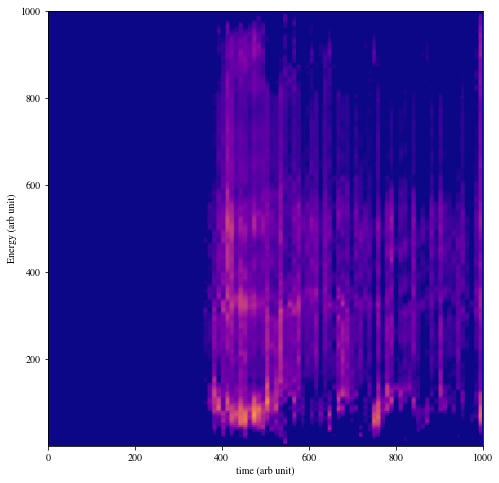

10/10 [==============================] - 163s 15s/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - lr: 7.9236e-04
Epoch 34/151
 1/10 [==>...........................] - ETA: 2:53 - loss: 0.0021 - mean_squared_error: 0.0021

KeyboardInterrupt: 

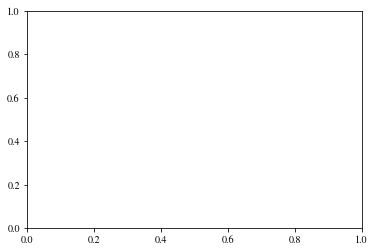

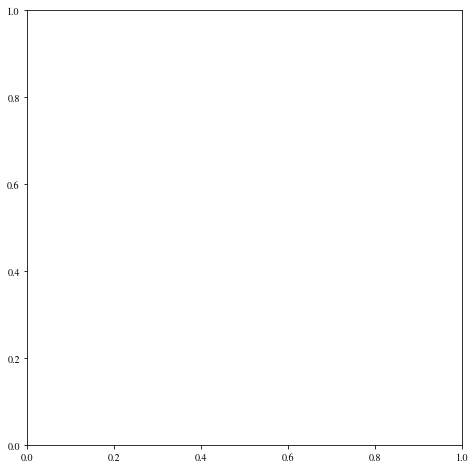

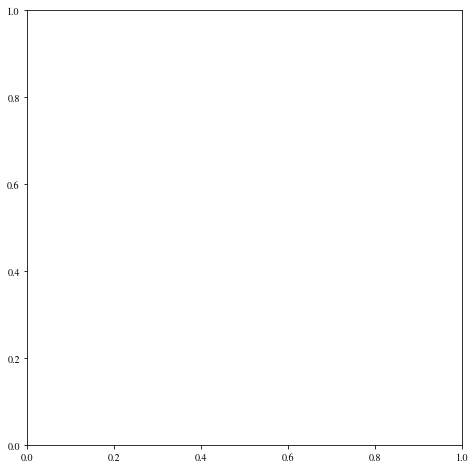

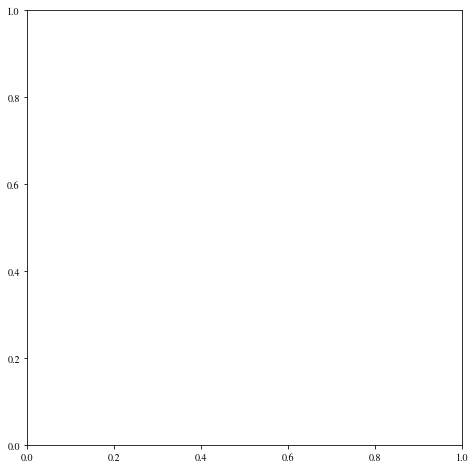

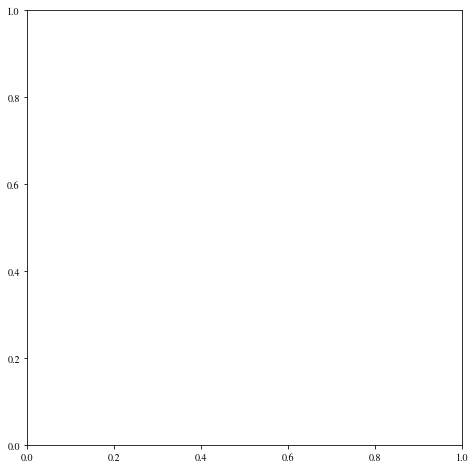

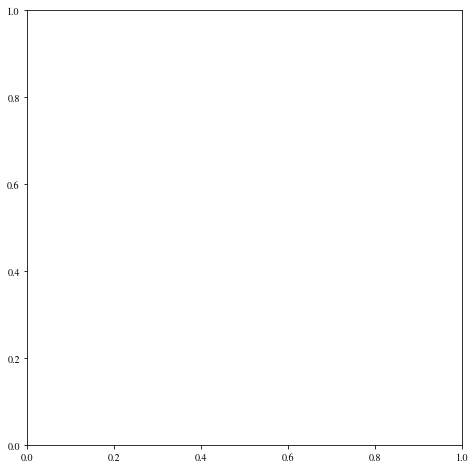

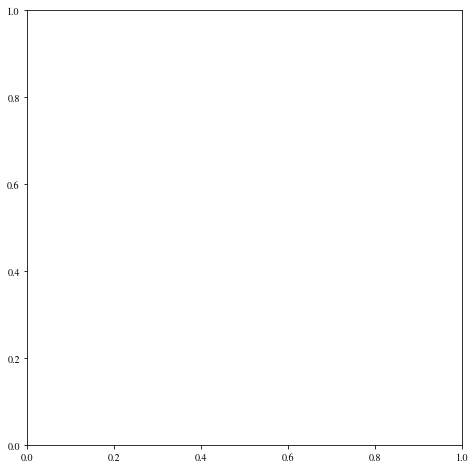

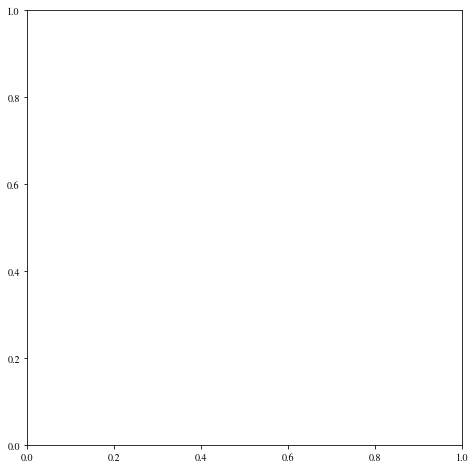

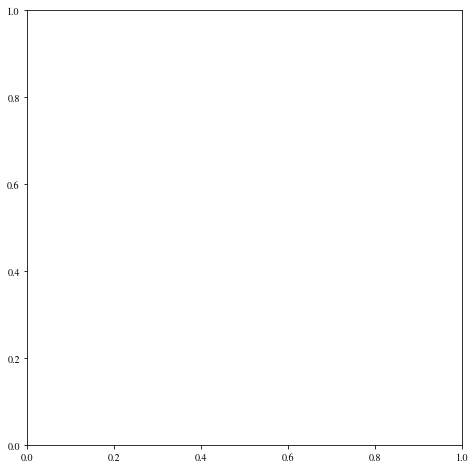

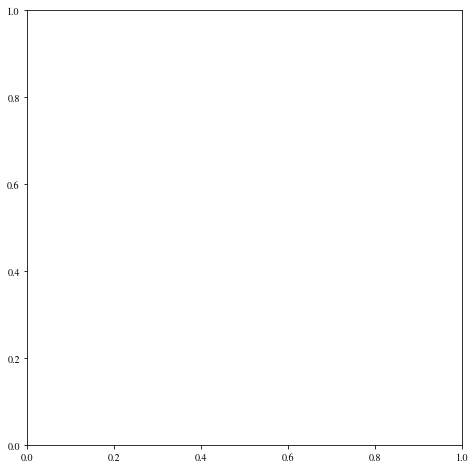

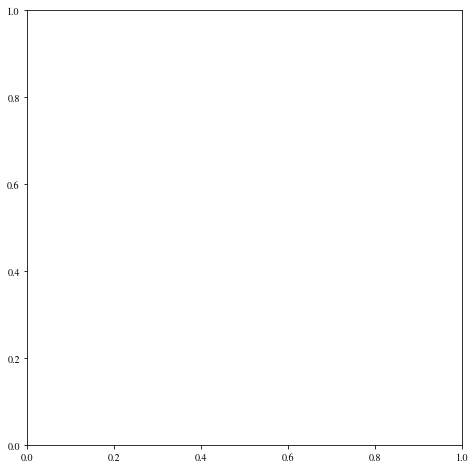

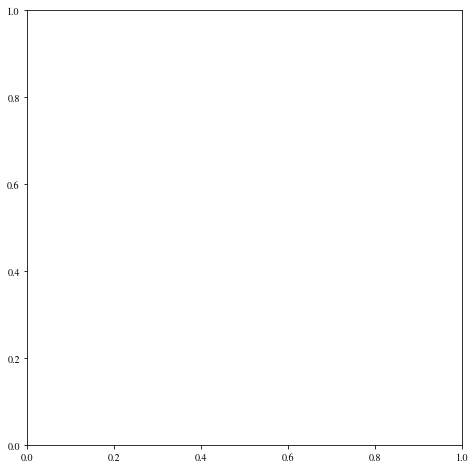

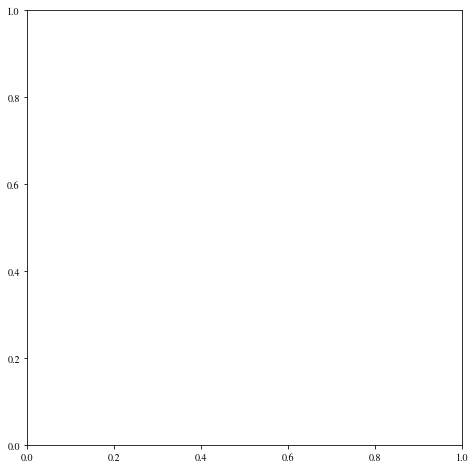

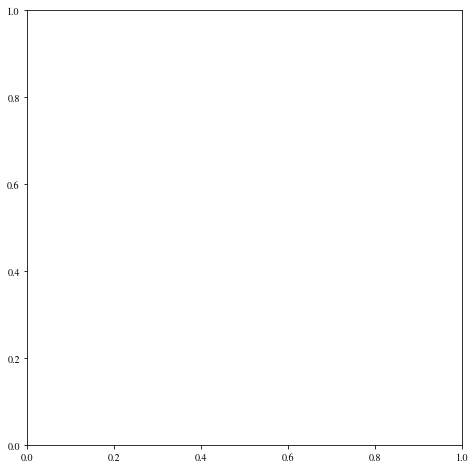

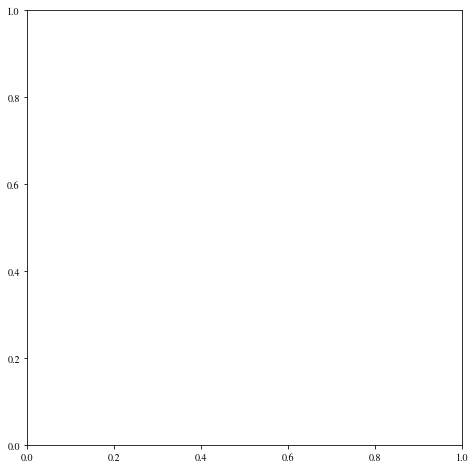

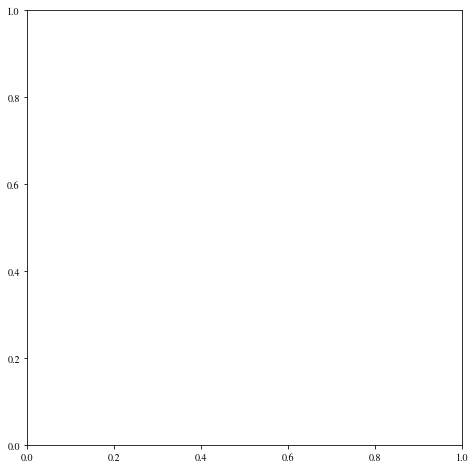

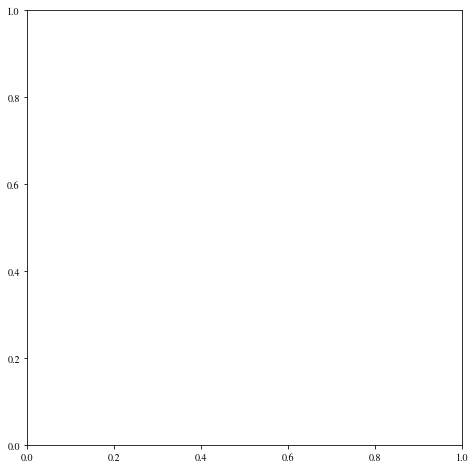

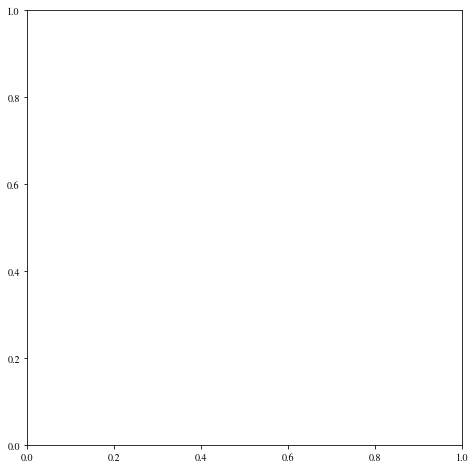

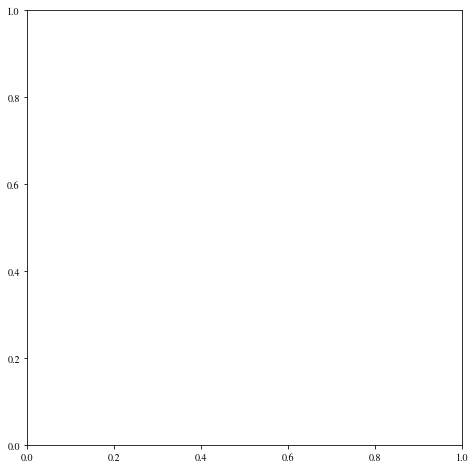

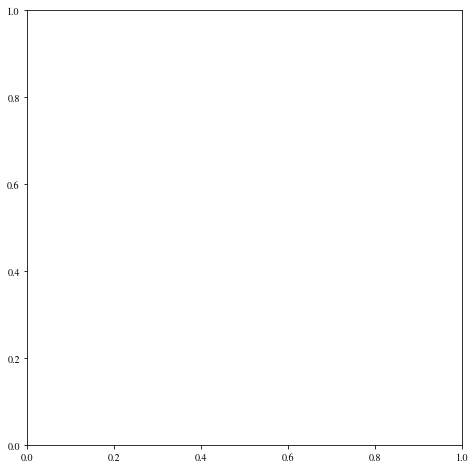

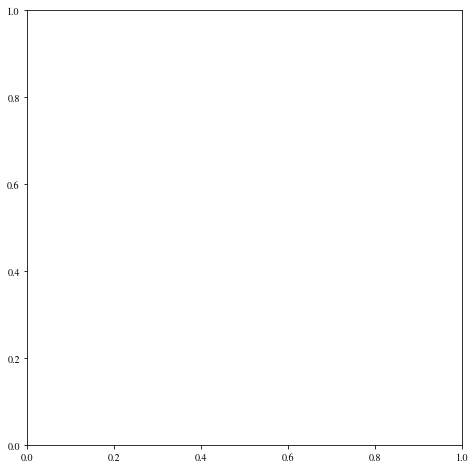

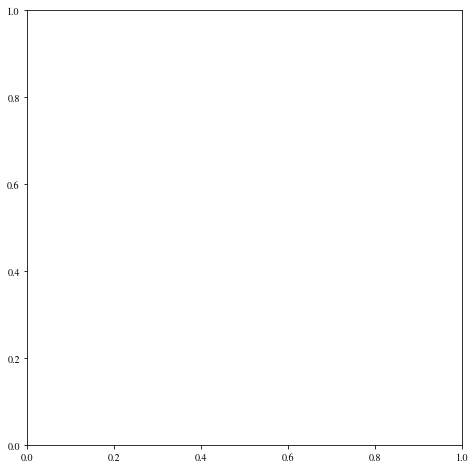

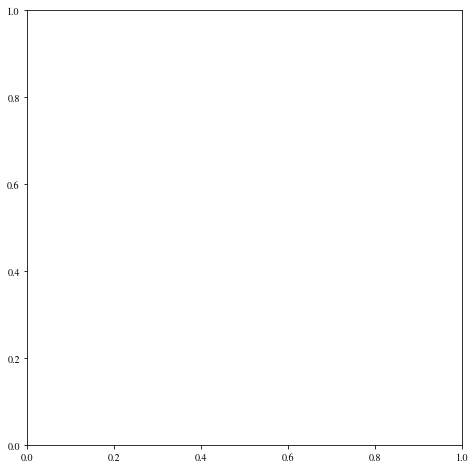

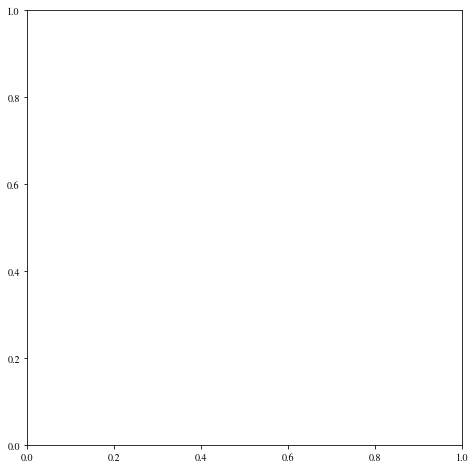

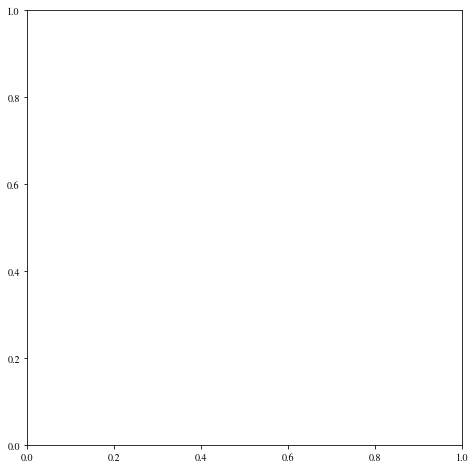

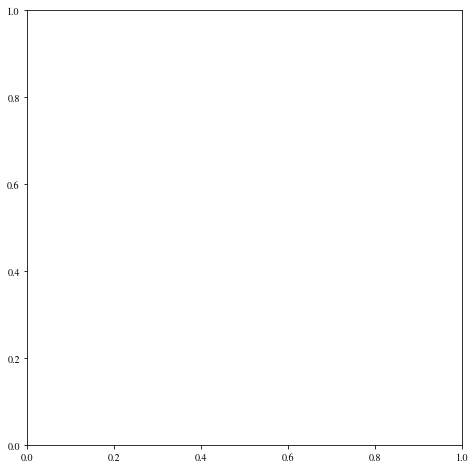

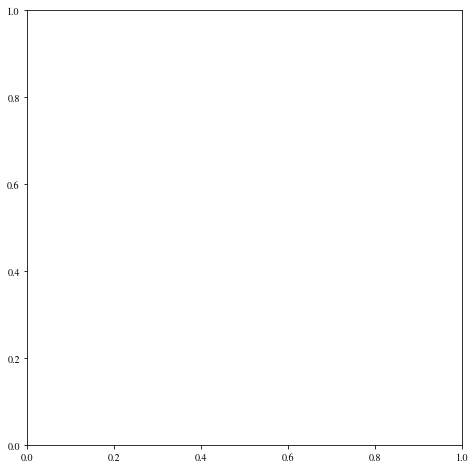

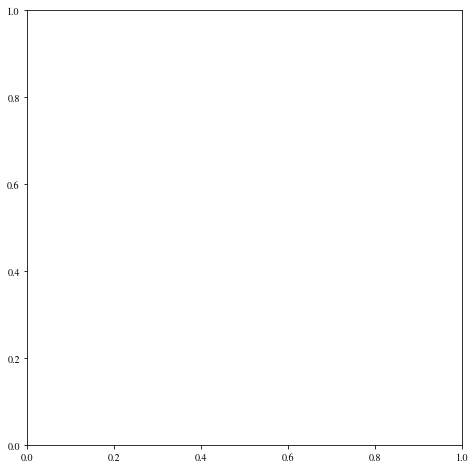

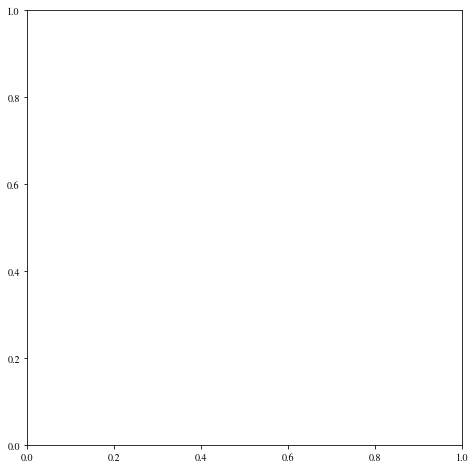

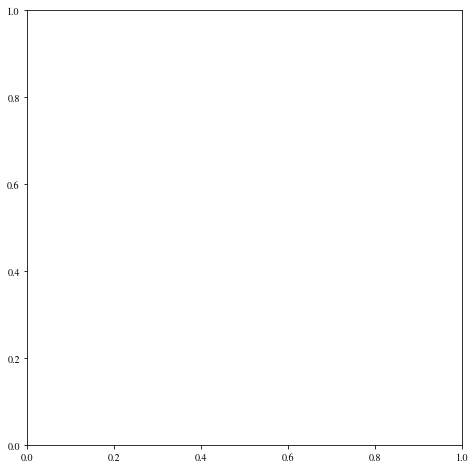

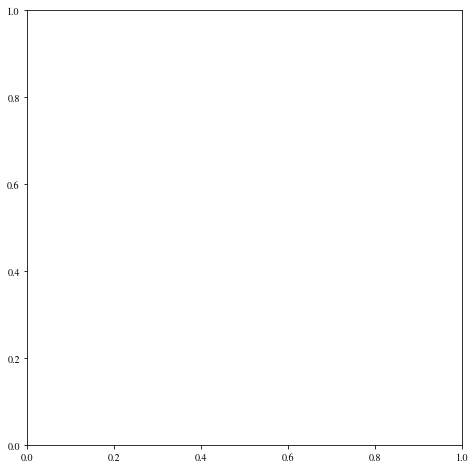

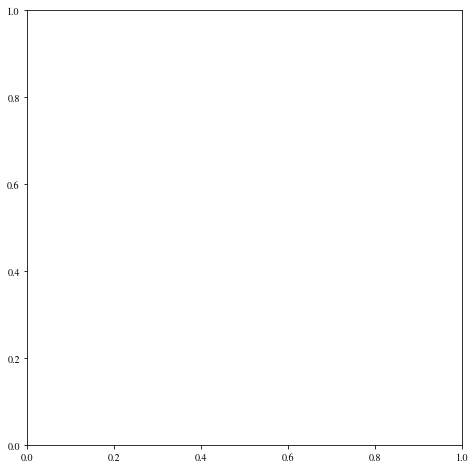

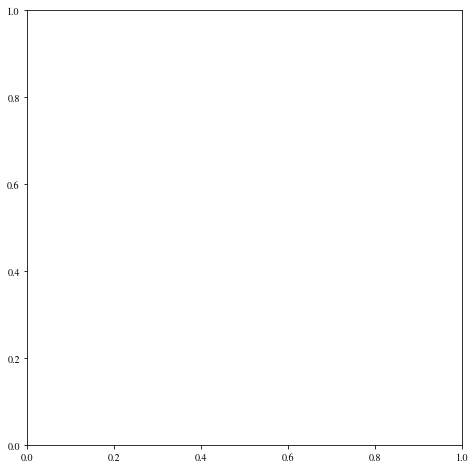

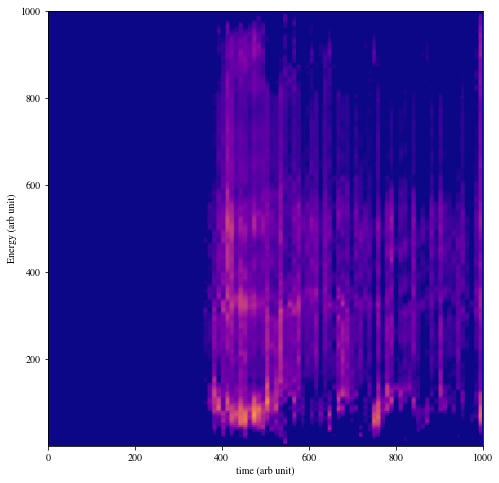

In [7]:
initial_lr = 0.001
final_lr = initial_lr/500
start_decay_epoch = 1
end_decay_epoch = 150
num_epochs = 151
model = Sequential()
number_units_in = 39
#model.add(Conv1D(number_units_in,kernel_size = 1, activation='relu', input_shape=(8, 1),padding='same'))
model.add(Dense(units=500,activation='LeakyReLU',input_shape=(8,1)))
#model.add(Dense(units=32,activation='LeakyReLU'))
#model.add(Dense(units=64,activation='relu'))
#model.add(Dense(units=103,activation='relu'))
#model.add(Dense(units=128,activation='relu'))
model.add(Conv1D(8,kernel_size = 3, activation='LeakyReLU',padding='same'))
model.add(UpSampling1D(2))
model.add(Conv1D(8,kernel_size = 3, activation='LeakyReLU',padding='same'))
model.add(UpSampling1D(2))
model.add(Conv1D(8,kernel_size = 3, activation='LeakyReLU',padding='same'))
model.add(UpSampling1D(2))
model.add(Conv1D(101,kernel_size = 3, activation='LeakyReLU',padding='same'))
model.add(UpSampling1D(2))
model.add(Reshape((128,101,1)))
model.add(Conv2D(8, (4, 4), activation='LeakyReLU'))
model.add(UpSampling2D(size=(2, 9), interpolation="nearest"))
#model.add(Conv2D(128, (2, 2), activation='relu',padding='same'))
#model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(Conv2D(100, (3, 3), activation='LeakyReLU',padding='same'))
model.add(Conv2D(1, (2, 2), activation='linear',padding='same'))



saver = CustomSaver(model)

def scheduler(epoch, lr):
    if epoch < start_decay_epoch:
        return lr
    if epoch >= start_decay_epoch and epoch < end_decay_epoch:
        return initial_lr -(initial_lr-final_lr)*((epoch - start_decay_epoch)/(end_decay_epoch - start_decay_epoch))
    else:
        return final_lr

model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_lr),loss="mean_squared_error", metrics = ['mean_squared_error'])
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
herstory = model.fit(Xtrain,ytrain,batch_size=32, verbose=1, callbacks=[saver,lr_callback],epochs=num_epochs, validation_data=(Xtest, ytest)) #validation_data=(Xtest, ytest) #saver
#trained_model = load_model('model_best_conv.hd5')

print(model.summary())

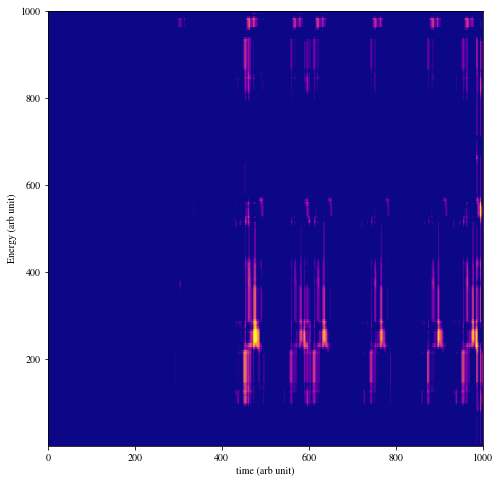

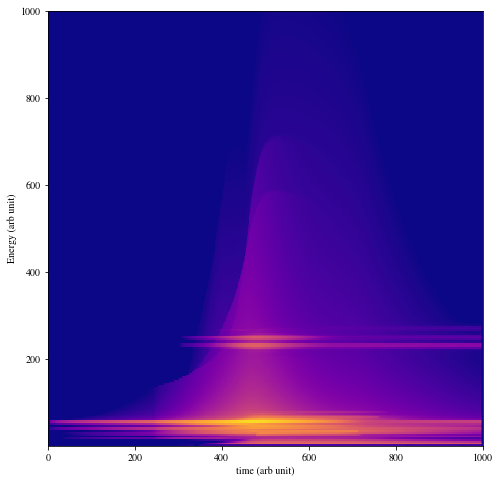

In [41]:

n = 8
pred1 = preds[n].reshape(ytest[n].shape)
estimation = glowplot(scaleback_pic(pred1,minval,maxval))
true = glowplot(scaleback_pic(ytest[n],minval,maxval))

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])


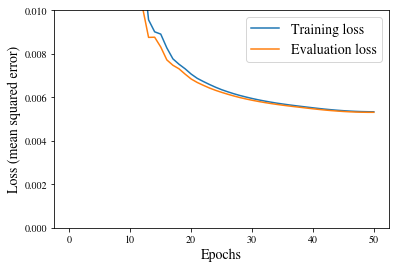

In [29]:

df2 = herstory.history
print(df2.keys())
training_loss = df2['mean_squared_error']
valuation_loss = df2['val_mean_squared_error']
epochs = list(range(0,num_epochs))
plt.clf()
plt.plot(epochs,training_loss,label='Training loss')
plt.plot(epochs,valuation_loss,label='Evaluation loss')
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Loss (mean squared error)',fontsize=14)
plt.ylim([0,0.01])
plt.legend(fontsize=14)
plt.savefig('/Users/harry/Pictures/latex_pics/loss.png')

plt.show()

In [6]:

class CustomSaver(keras.callbacks.Callback):
    def __init__(self,model):
        self.minloss = 100000
        self.num_epochs = num_epochs
        self.progress = []
    def on_epoch_end(self, epoch, logs={}):
            if epoch % 1 == 0:
                y = model.predict(Xtest,verbose = 0)
                pred = y[0].reshape(ytest[0].shape)
                tm = scaleback_pic(pred,minval,maxval)
                HPEV = 4.135667516E-15  # Planks constant [eV s]
                ERG2J = 1E-7
                E1 = 2000  # [eV]
                E2 = E1 * 1.001  # [eV]
                mult = HPEV / (E2 - E1)
                tm = (4*np.pi * ERG2J * tm)/mult
                plt.cla()
                fig,ax=plt.subplots(figsize=(8,8))
                plt.ylim([1E-1, 1E3])
                im=plt.imshow(tm,norm=colors.LogNorm(),extent=[0, 1000, 0, 1000],cmap='plasma',origin='lower', interpolation='nearest')
                #ax.set_yscale('log')
                plt.ylabel('Energy (arb unit)')
                plt.xlabel('time (arb unit)')
                plt.clim([1E3, 1E12])
                display.clear_output(wait=True)
                display.display(plt.gcf())



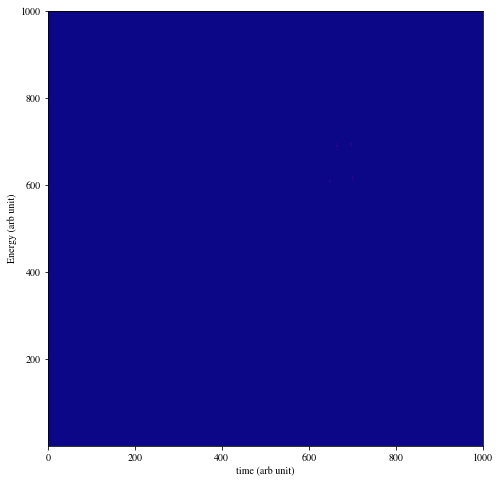

5/5 [==============================] - 41s 8s/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 25/300
1/5 [=====>........................] - ETA: 36s - loss: 0.0026 - mean_squared_error: 0.0026

KeyboardInterrupt: 

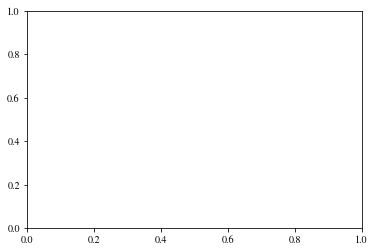

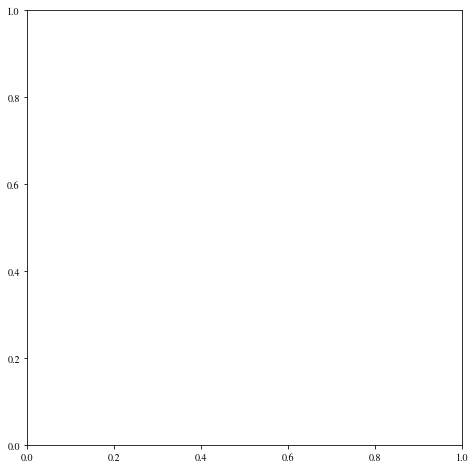

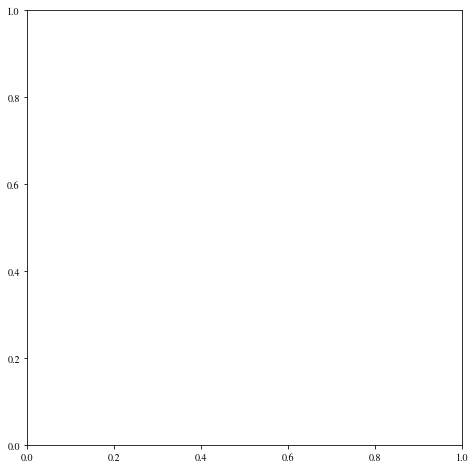

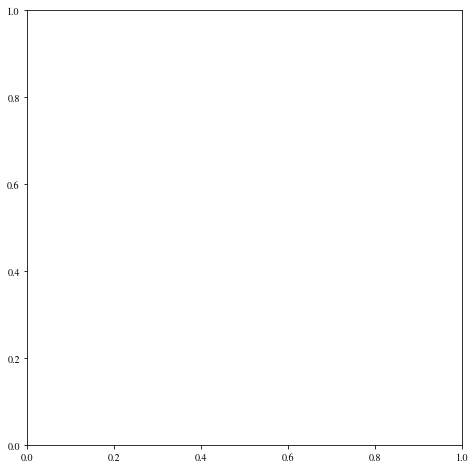

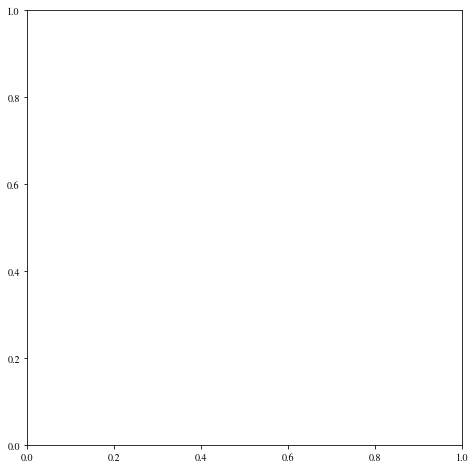

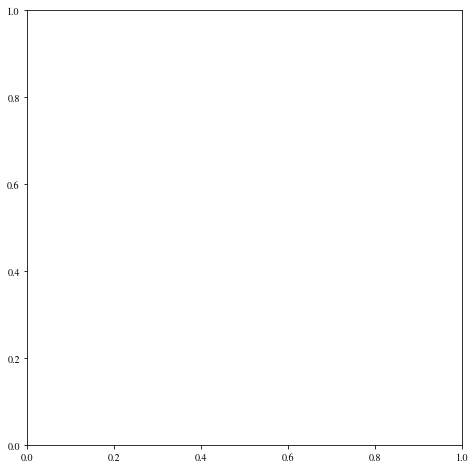

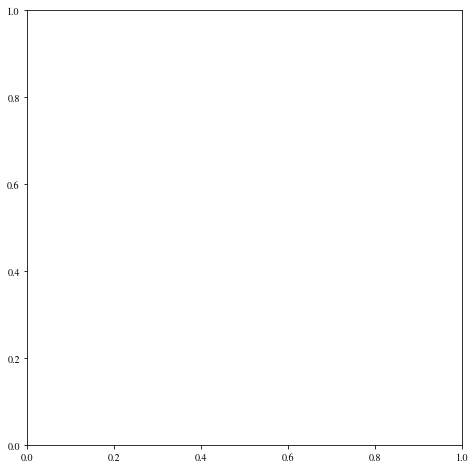

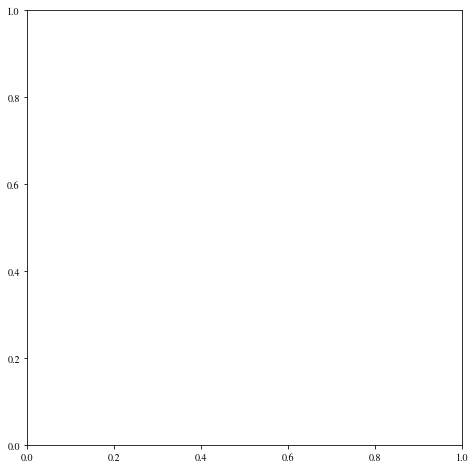

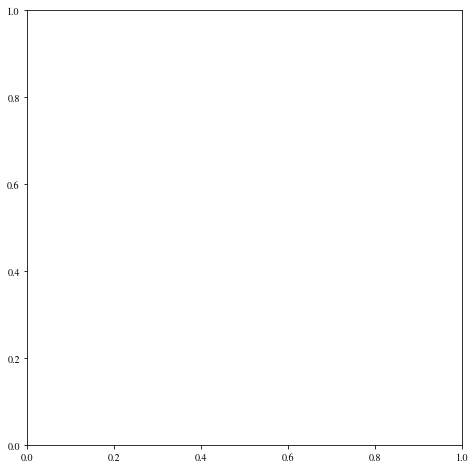

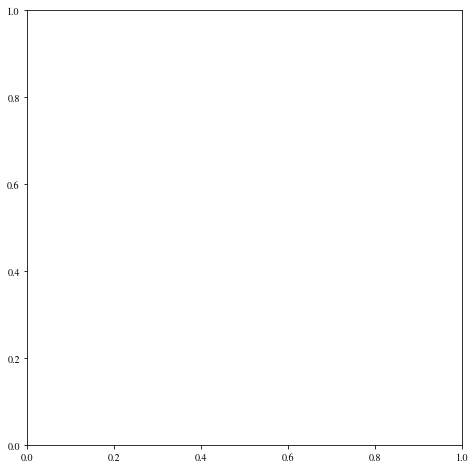

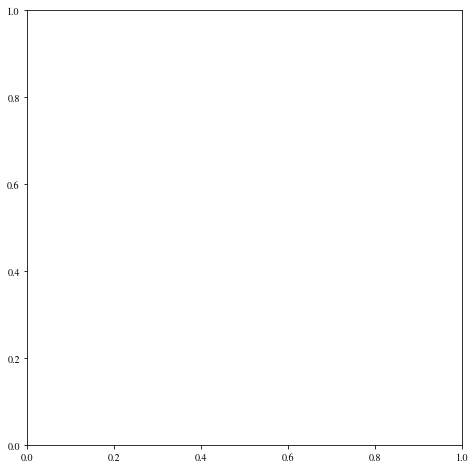

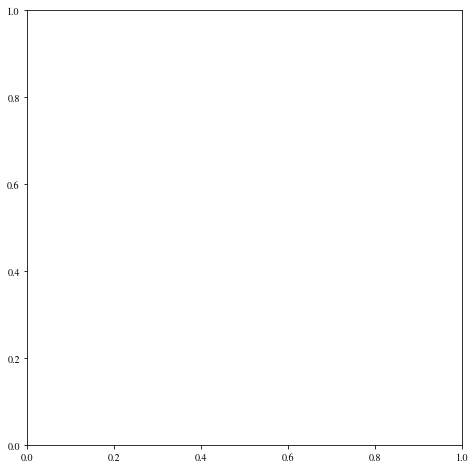

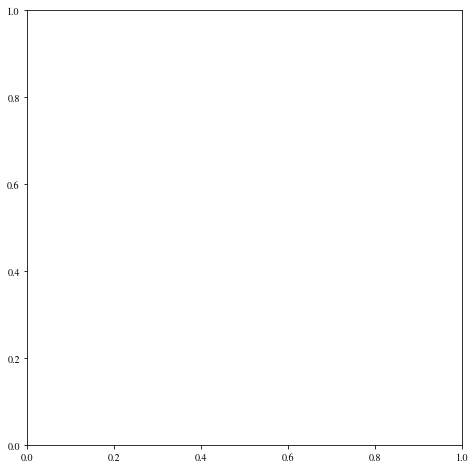

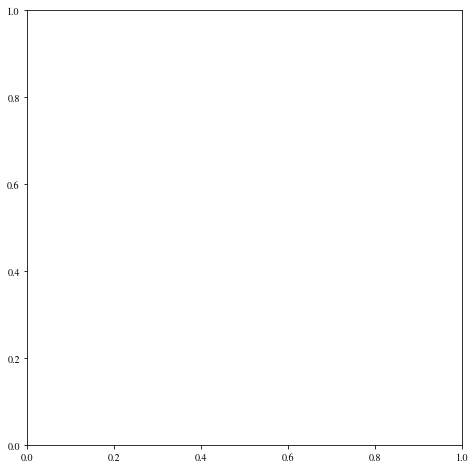

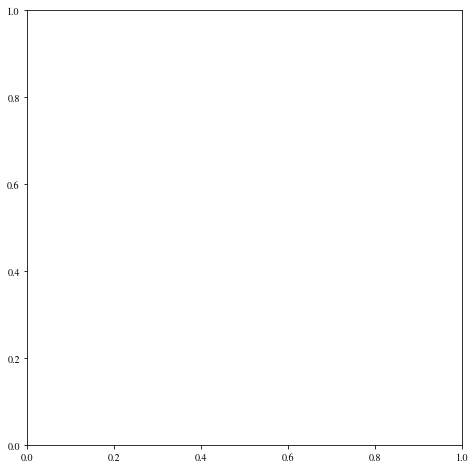

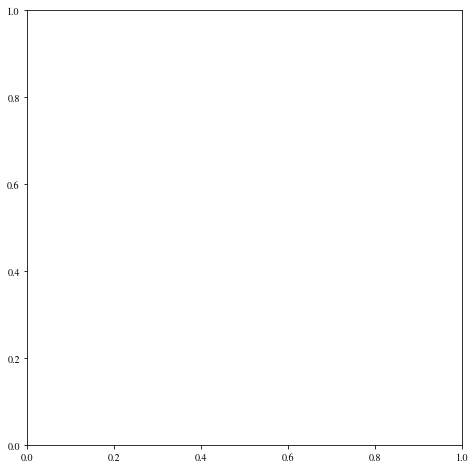

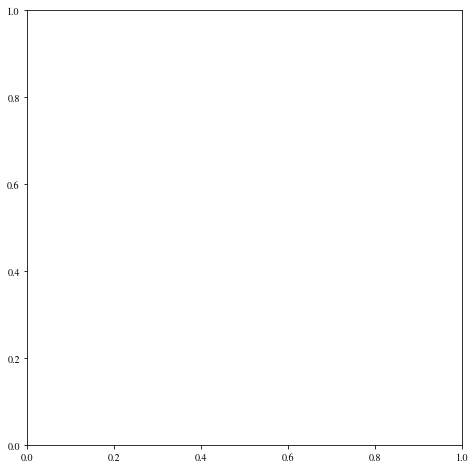

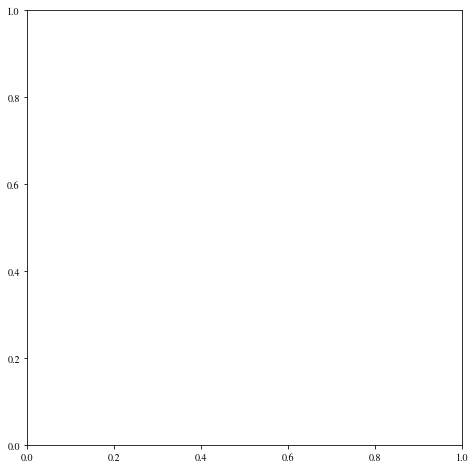

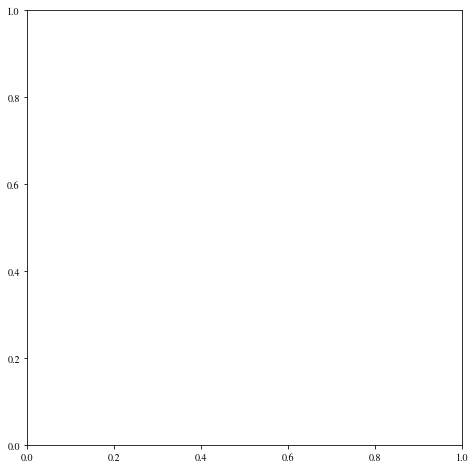

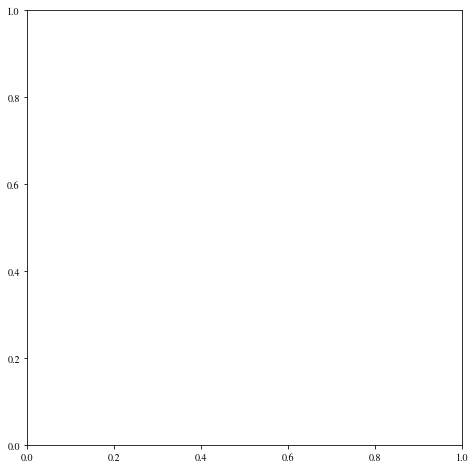

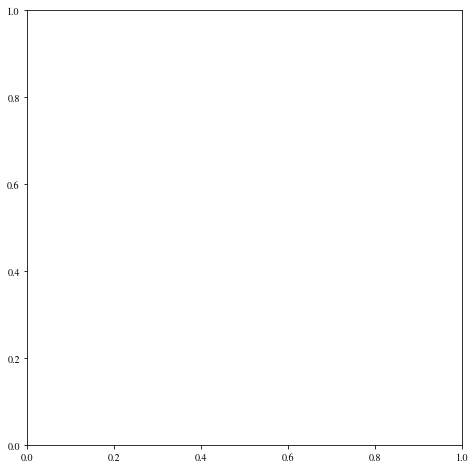

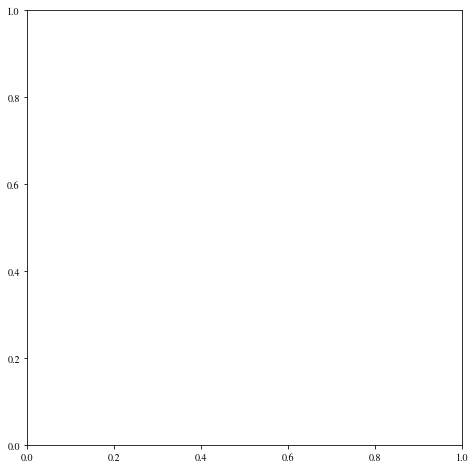

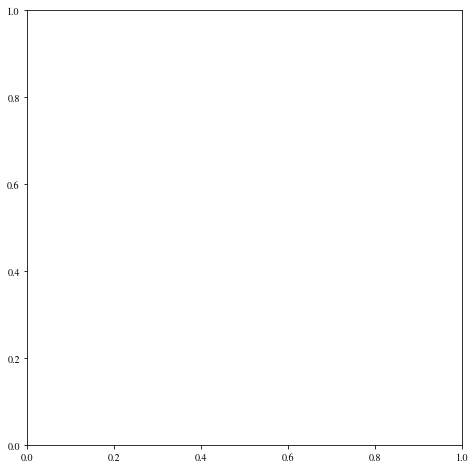

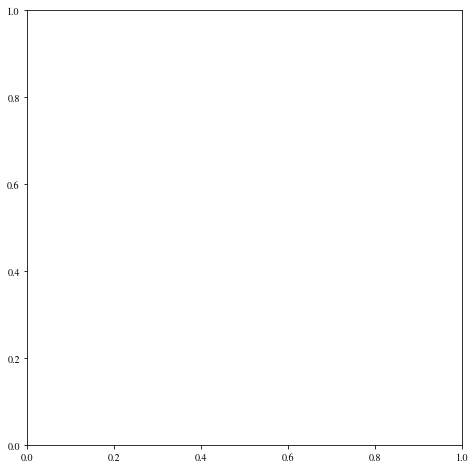

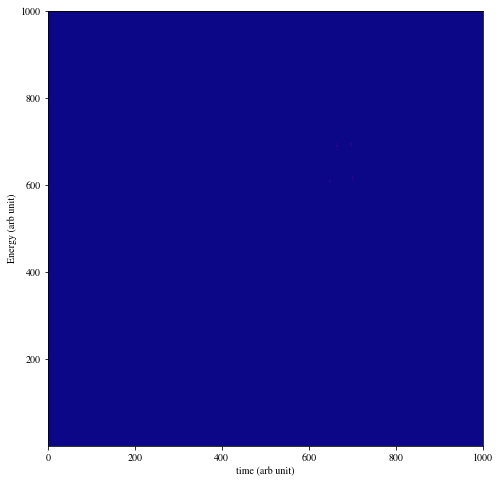

In [33]:
num_epochs = 300
model = Sequential()
model.add(Dense(32,activation='relu',input_shape=(8, 1)))
model.add(Reshape((8,32,1)))
model.add(Conv2D(32, (2, 2), activation='relu'))
#model.add(BatchNormalization())
model.add(Conv2DTranspose(filters=32,kernel_size=3,strides=(3, 2),padding="same"))
#model.add(Conv2D(1, (3, 3), activation='LeakyReLU'))
model.add(Conv2DTranspose(filters=32,kernel_size=3,strides=(3, 2),padding="same"))
#model.add(Conv2D(1, (3, 3), activation='LeakyReLU',padding='same'))
model.add(Conv2DTranspose(filters=32,kernel_size=3,strides=(2, 3),padding="same"))
model.add(Conv2D(32, (3, 3), activation='relu',padding="same"))
#model.add(BatchNormalization())
model.add(Conv2DTranspose(filters=32,kernel_size=3,strides=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(Conv2D(32, (2, 2), activation='relu'))

model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(Conv2D(1, (3, 3), activation='relu',padding='same'))

saver = CustomSaver(model)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss="mean_squared_error", metrics = ['mean_squared_error'])
herstory = model.fit(Xtrain,ytrain,batch_size=16, verbose=1,callbacks=[saver], epochs=num_epochs, validation_data=(Xtest, ytest)) #validation_data=(Xtest, ytest) #saver
#trained_model = load_model('model_best_conv.hd5')

print(model.summary())

In [271]:
preds = model.predict(Xtest)


1/1 [==============================] - 0s 295ms/step


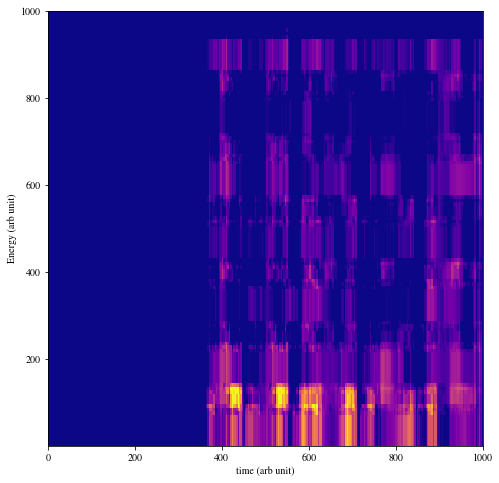

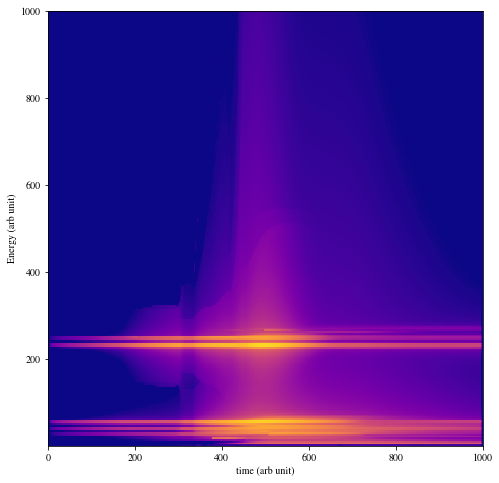

In [292]:
preds = model.predict(Xtest)
n = 1
pred1 = preds[n].reshape(ytest[n].shape)
estimation = glowplot(scaleback_pic(pred1,minval,maxval))
true = glowplot(scaleback_pic(ytest[n],minval,maxval))